Train Sentiment Analysis Classifier using Self Attention 
============================================

Recently, the “attention” mechanism has become one of the core techniques in Deep Learning throughout a variety of domains after its huge initial success in Neural Machine Translation (NMT). He we train a sentence classifier to identify positive or negative sentiments using the self attention mechanism. We used spacy for data-processing and seaborn for visualization.

## Data Loading and Preprocessing using spaCy

In [27]:
import mxnet as mx
import numpy as np
import pandas as pd
import nlp_utils
import spacy
nlp = spacy.load("en")

In [2]:
x, y, origin_txt, vocab_size, idx2word, word2idx = nlp_utils.preprocess()

Count words and build vocab...
Prepare data...
   yn  index
0   0   3091
1   1   3995


In [3]:
## Data process - tr/va split and define iterator

tr_idx = np.random.choice(range(len(x)), int(len(x) * .8))
va_idx = [x for x in range(len(x)) if x not in tr_idx]

tr_x = [x[i] for i in tr_idx]
tr_y = [y[i] for i in tr_idx]
tr_origin = [origin_txt[i] for i in tr_idx]

va_x = [x[i] for i in va_idx]
va_y = [y[i] for i in va_idx]
va_origin = [origin_txt[i] for i in va_idx]

batch_size = 16
learning_rate = .0002
log_interval = 100


train_data = mx.io.NDArrayIter(data=[tr_x, tr_y], batch_size=batch_size, shuffle = False)
valid_data = mx.io.NDArrayIter(data=[va_x, va_y], batch_size=batch_size, shuffle = False)

## Sentence Representation

In [4]:
from mxnet import gluon, autograd, nd
from mxnet.gluon import nn, rnn
from mxnet.ndarray.linalg import gemm2
import mxnet as mx
context = mx.gpu()

In [5]:
class Sentence_Representation(nn.Block):
    def __init__(self, **kwargs):
        super(Sentence_Representation, self).__init__()
        for (k, v) in kwargs.items():
            setattr(self, k, v)
        
        with self.name_scope():
            self.embed = nn.Embedding(self.vocab_size, self.emb_dim)
            self.drop = nn.Dropout(.2)
            self.bi_rnn = rnn.BidirectionalCell(
                 rnn.LSTMCell(hidden_size = self.hidden_dim // 2),  #mx.rnn.LSTMCell doesnot work
                 rnn.LSTMCell(hidden_size = self.hidden_dim // 2)
            )
            self.w_1 = nn.Dense(self.d, use_bias = False)
            self.w_2 = nn.Dense(self.r, use_bias = False)

    def forward(self, x, hidden):
        embeds = self.embed(x) # batch * time step * embedding
        h, _ = self.bi_rnn.unroll(length = embeds.shape[1] \
                                       , inputs = embeds \
                                       , layout = 'NTC' \
                                       , merge_outputs = True)
        # For understanding
        batch_size, time_step, _ = h.shape
        # get self-attention
        _h = h.reshape((-1, self.hidden_dim))
        _w = nd.tanh(self.w_1(_h))
        w = self.w_2(_w)
        _att = w.reshape((-1, time_step, self.r)) # Batch * Timestep * r
        att = nd.softmax(_att, axis = 1)
        x = gemm2(att, h, transpose_a = True)  # h = Batch * Timestep * (2 * hidden_dim), a = Batch * Timestep * r
        return x, att

## Classifier

In [6]:
classifier = nn.Sequential()
classifier.add(nn.Dense(16, activation = 'relu'))
classifier.add(nn.Dense(8, activation = 'relu'))
classifier.add(nn.Dense(1))
classifier.collect_params().initialize(mx.init.Xavier(), ctx = context)

## Sentiment analysis classifier

In [7]:
class SA_SA_Classifier(nn.Block):
    def __init__(self, sen_rep, classifier, context, **kwargs):
        super(SA_SA_Classifier, self).__init__(**kwargs)
        self.context = context
        with self.name_scope():
            self.sen_rep = sen_rep
            self.classifier = classifier
            
    def forward(self, x):
        # Initial hidden state
        hidden = self.sen_rep.bi_rnn.begin_state()

        lstm_out, att = self.sen_rep(x, hidden)
        x = nd.flatten(lstm_out)
        res = self.classifier(x)
        return res, att         

In [8]:
emb_dim = 100 # Emb dim
hidden_dim = 20 # Hidden dim for LSTM

#### Initiate sentiment classifier

In [9]:
emb_dim = 50 # Emb dim
hidden_dim = 30 # Hidden dim for LSTM

param = {'emb_dim': emb_dim, 'hidden_dim': hidden_dim, 'vocab_size': vocab_size, 'd': 10, 'r': 5, 'dropout': .2}
sen_rep = Sentence_Representation(**param)
sen_rep.collect_params().initialize(mx.init.Xavier(), ctx = context)


In [10]:
sa = SA_SA_Classifier(sen_rep, classifier, context)
loss = gluon.loss.SigmoidBCELoss()
trainer = gluon.Trainer(sa.collect_params(), 'adam', {'learning_rate': 1e-3})

In [11]:
def evaluate(net, dataIterator, context):
    dataIterator.reset()
    loss = gluon.loss.SigmoidBCELoss()
    total_L = 0.0
    total_sample_num = 0
    total_correct_num = 0
    start_log_interval_time = time.time()
    for i, batch in enumerate(dataIterator):
        data =  batch.data[0].as_in_context(context)
        label = batch.data[1].as_in_context(context)
        output, att = net(data)
        L = loss(output, label)
        pred = (output > 0.5).reshape((-1,))
        total_L += L.sum().asscalar()
        total_sample_num += len(label)
        total_correct_num += (pred == label).sum().asscalar()
        if (i + 1) % log_interval == 0:
            print('[Batch {}/{}] elapsed {:.2f} s'.format(
                i + 1, dataIterator.num_data//dataIterator.batch_size,
                time.time() - start_log_interval_time))
            start_log_interval_time = time.time()
    avg_L = total_L / float(total_sample_num)
    acc = total_correct_num / float(total_sample_num)
    return avg_L, acc

In [14]:
from tqdm import tqdm, tqdm_notebook
import time

n_epoch = 5
for epoch in tqdm_notebook(range(n_epoch), desc = 'epoch'):
    ## Training
    train_data.reset()
    # Epoch training stats
    start_epoch_time = time.time()
    epoch_L = 0.0
    epoch_sent_num = 0
    epoch_wc = 0
    # Log interval training stats
    start_log_interval_time = time.time()
    log_interval_wc = 0
    log_interval_sent_num = 0
    log_interval_L = 0.0
    
    for i, batch in enumerate(train_data):
        _data = batch.data[0].as_in_context(context)
        _label = batch.data[1].as_in_context(context)
        L = 0
        wc = len(_data)
        log_interval_wc += wc
        epoch_wc += wc
        log_interval_sent_num += _data.shape[1]
        epoch_sent_num += _data.shape[1]
        with autograd.record():
            _out, att = sa(_data)
            pen = gemm2(att, att, transpose_b = True)
            # Penalty
            tmp = nd.dot(att[0], att[0].T) -nd.array(np.identity(att[0].shape[0]), ctx = context)
            pen = nd.sum(nd.multiply(nd.abs(tmp), nd.abs(tmp)))
            L = L + loss(_out, _label).mean().as_in_context(context) + .5 * pen
        L.backward()
        trainer.step(_data.shape[0])
        log_interval_L += L.asscalar()
        epoch_L += L.asscalar()
        if (i + 1) % log_interval == 0:
            tqdm.write('[Epoch {} Batch {}/{}] elapsed {:.2f} s, \
                    avg loss {:.6f}, throughput {:.2f}K wps'.format(
                    epoch, i + 1, train_data.num_data//train_data.batch_size,
                    time.time() - start_log_interval_time,
                    log_interval_L / log_interval_sent_num,
                    log_interval_wc / 1000 / (time.time() - start_log_interval_time)))
            # Clear log interval training stats
            start_log_interval_time = time.time()
            log_interval_wc = 0
            log_interval_sent_num = 0
            log_interval_L = 0
    end_epoch_time = time.time()
    test_avg_L, test_acc = evaluate(sa, valid_data, context)
    tqdm.write('[Epoch {}] train avg loss {:.6f}, valid acc {:.2f}, \
        valid avg loss {:.6f}, throughput {:.2f}K wps'.format(
        epoch, epoch_L / epoch_sent_num,
        test_acc, test_avg_L, epoch_wc / 1000 /
        (end_epoch_time - start_epoch_time)))

[Epoch 0 Batch 100/354] elapsed 5.71 s,                     avg loss 0.518012, throughput 0.28K wps
[Epoch 0 Batch 200/354] elapsed 5.75 s,                     avg loss 0.486638, throughput 0.28K wps
[Epoch 0 Batch 300/354] elapsed 5.83 s,                     avg loss 0.476489, throughput 0.27K wps
[Batch 100/200] elapsed 3.01 s
[Batch 200/200] elapsed 2.80 s
[Epoch 0] train avg loss 0.490109, valid acc 0.98,         valid avg loss 0.062835, throughput 0.28K wps
[Epoch 1 Batch 100/354] elapsed 5.78 s,                     avg loss 0.454611, throughput 0.28K wps
[Epoch 1 Batch 200/354] elapsed 5.83 s,                     avg loss 0.440609, throughput 0.27K wps
[Epoch 1 Batch 300/354] elapsed 5.72 s,                     avg loss 0.433833, throughput 0.28K wps
[Batch 100/200] elapsed 2.75 s
[Batch 200/200] elapsed 2.81 s
[Epoch 1] train avg loss 0.440658, valid acc 0.98,         valid avg loss 0.063350, throughput 0.28K wps
[Epoch 2 Batch 100/354] elapsed 5.77 s,                     avg lo

### Prediction

In [15]:
def get_pred(net, iterator):
    pred_sa = []
    label_sa = []
    va_text = []
    iterator.reset()
    for i, batch in enumerate(iterator):
        if i % 100 == 0:
            print('i = {}'.format(i))
        data =  batch.data[0].as_in_context(context)
        label = batch.data[1].as_in_context(context)
        output, _ = net(data)
        L = loss(output, label)
        pred = (nd.sigmoid(output) > 0.5).reshape((-1,))
        pred_sa.extend(pred.asnumpy())
        label_sa.extend(label.asnumpy())
        va_text.extend([' '.join([idx2word[np.int(x)] for x in y.asnumpy() if idx2word[np.int(x)] is not 'PAD']) for y in data])
    pred_sa_pd = pd.DataFrame(pred_sa, columns  = ['pred_sa'])
    label_pd = pd.DataFrame(label_sa, columns = ['label'])
    text_pd = pd.DataFrame(va_text, columns = ['text'])
    res = pd.concat([text_pd, pred_sa_pd, label_pd], axis = 1)
    return res

## Classification results

In [18]:
result = get_pred(sa, valid_data)

i = 0
i = 100
i = 200


In [19]:
result[result.pred_sa != result.label].shape

(58, 3)

In [20]:
result.shape

(3216, 3)

In [21]:
result[result.pred_sa != result.label].head(10)

,text,pred_sa,label
3,that not even an exaggeration and at midnight ...,0.0,1.0
12,the da vinci code backtory on various religiou...,0.0,1.0
14,and then go to see the da vinci code which be ...,0.0,1.0
48,and love da vinci code illustrate edition be t...,0.0,1.0
81,agree with love da vinci code just think ridic...,0.0,1.0
533,have some awesome time at school in between cl...,0.0,1.0
534,hate though because really like mission imposs...,0.0,1.0
537,hate though because really like mission imposs...,0.0,1.0
548,mission impossible be soo so good,0.0,1.0
557,what like to see be some mission impossible st...,0.0,1.0


#### Erroneous results

In [22]:
result[result.pred_sa != result.label]['text'].iloc[3]

'and love da vinci code illustrate edition be the only way to go'

## Visualize attention

In [23]:
def plot_attention(net, n_samples = 10, mean = False):
    from matplotlib import pyplot as plt
    import seaborn as sns
    sns.set()
    idx = np.random.choice(np.arange(len(va_x)), size = n_samples, replace = False)
    _dat = [va_x[i] for i in idx]
    
    w_idx = []
    word = [[idx2word[x] for x in y] for y in _dat]
    original_txt = [va_origin[i] for i in idx]
    out, att = net(nd.array(_dat, ctx = context)) 
    print('attention shape = {}'.format(att.shape))
    _a = []
    _w = []
    for x, y, z in zip(word, att, original_txt):
        _idx = [i for i, _x in enumerate(x) if _x is not 'PAD']
        _w.append(np.array([x[i] for i in _idx]))
        _a.append(np.array([y[i].asnumpy() for i in _idx]))
        
    _label = [va_y[i] for i in idx]
    _pred = (nd.sigmoid(out) > .5).asnumpy()
    
    fig, axes = plt.subplots(np.int(np.ceil(n_samples / 4)), 4, sharex = False, sharey = True)
    plt.subplots_adjust(hspace=1)
    if mean == True:
        fig.set_size_inches(20, 4)
        plt.subplots_adjust(hspace=5)
    else:
        fig.set_size_inches(20, 20)
        plt.subplots_adjust(hspace=1)
    cbar_ax = fig.add_axes([.91, .3, .04, .4])
    
    
    
    for i in range(n_samples):
        if mean == True:
            _data = nd.softmax(nd.array(np.mean(_a[i], axis = 1))).asnumpy()
            sns.heatmap(pd.DataFrame(_data, index = _w[i]).T, ax = axes.flat[i], cmap = 'RdYlGn', linewidths = .3, cbar_ax = cbar_ax)
        else:
            sns.heatmap(pd.DataFrame(_a[i], index = _w[i]).T, ax = axes.flat[i], cmap = 'RdYlGn', linewidths = .3, cbar_ax = cbar_ax)
        axes.flat[i].set_title('Label: {}, Pred: {}'.format(_label[i], np.int(_pred[i])))


In [24]:
# https://stackoverflow.com/questions/49899823/changing-width-of-heatmap-in-seaborn-to-compensate-for-font-size-reduction
def plot_neuron_heatmap(text, values, title, n_limit=80, savename='fig1.png',
                        cell_height=0.325, cell_width=0.15, dpi=100):
    from matplotlib import pyplot as plt
    import seaborn as sns
    text = text.replace('\n', '\\n')
    text = np.array(list(text + ' ' * (-len(text) % n_limit)))
    if len(values) > text.size:
        values = np.array(values[:text.size])
    else:
        t = values
        values = np.zeros(text.shape, dtype=np.float32)
        values[:len(t)] = t
    text = text.reshape(-1, n_limit)
    values = values.reshape(-1, n_limit)
    plt.figure(figsize=(cell_width * n_limit, cell_height * len(text)))
    hmap = sns.heatmap(values, annot=text, fmt='', cmap='RdYlGn', xticklabels=False, yticklabels=False, cbar=False)
    plt.subplots_adjust()
    plt.title(title)
    #plt.savefig(savename, dpi=dpi)

In [25]:
def draw_sentence(_idx):
    # Get data from valid set for _idx
    _dat = [va_x[i] for i in _idx]

    w_idx = []
    word = [[idx2word[x] for x in y] for y in _dat]
    original_txt = [va_origin[i] for i in _idx]
    out, att = sa(nd.array(_dat, ctx = context)) 
    _a = []
    _w = []
    for x, y, z in zip(word, att, original_txt):
        _ix = [i for i, _x in enumerate(x) if _x is not 'PAD']
        _w.append(np.array([x[i] for i in _ix]))
        _a.append(np.array([y[i].asnumpy() for i in _ix]))

    _label = [va_y[i] for i in _idx]
    _pred = (nd.sigmoid(out) > .5).asnumpy()

    for i, _ix in enumerate(_idx):
        att_score = [] 
        _b = nd.softmax(nd.array(np.mean(_a[i], axis = 1))).asnumpy()
        for x in original_txt[i].split(' '):
            _x_lem = [token.lemma_ for token in nlp(x) if token.is_alpha]
            if len(_x_lem) > 0:
                x_lemma = [token.lemma_ for token in nlp(x) if token.is_alpha][0]
            else:
                x_lemma = ''
            if x_lemma in _w[i]:
                idx = np.argmax(x_lemma == _w[i])
                tmp = [_b[idx]] * len(x)
            else:
                idx = -1
                tmp = [1/len(_w[i])] * len(x)
            tmp.extend([1/len(_w[i])])
            att_score.extend(tmp)
        plot_neuron_heatmap(original_txt[i], att_score[:-1] \
                          , 'Label: {}, Pred: {}'.format(_label[i], np.int(_pred[i])) \
                          , n_limit= len(att_score[:-1]))

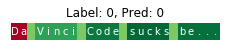

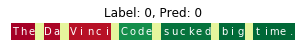

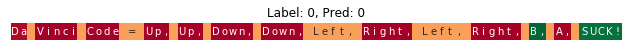

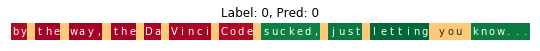

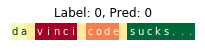

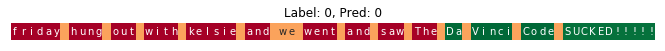

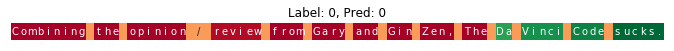

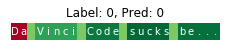

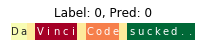

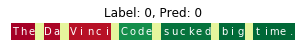

In [34]:
draw_sentence(np.arange(2000, 2010))